In [1]:
from nb_setup import *

autoreload 3 enabled
ROOT_DIR: /home/jp/projects/kaggle-HuBMAP
Host name: doomfist


## TIF images

In [14]:
import numpy as np

from kaggle_hubmap.data_utils.core import get_paths, make_concurrent
from kaggle_hubmap.data_utils.image import get_image_meta

In [3]:
trn_src = '/hdd-pool/hubmap-hacking-the-human-vasculature/train/'
tst_src = '/hdd-pool/hubmap-hacking-the-human-vasculature/test/'

In [5]:
trn_paths = get_paths(trn_src, '.tif')
tst_paths = get_paths(tst_src, '.tif')

INFO:kaggle_hubmap.data_utils.core:Found 7033 paths in "/hdd-pool/hubmap-hacking-the-human-vasculature/train/" matching keyword ".tif"
INFO:kaggle_hubmap.data_utils.core:Found 1 paths in "/hdd-pool/hubmap-hacking-the-human-vasculature/test/" matching keyword ".tif"


In [9]:
get_image_meta(trn_paths[100])

{'img_id': '033a656390b2',
 'img_name': '033a656390b2.tif',
 'img_ext': '.tif',
 'img_dir': PosixPath('/hdd-pool/hubmap-hacking-the-human-vasculature/train'),
 'img_shape': (512, 512, 3),
 'img_size': 628002,
 'img_mean': 138.84621938069662,
 'img_std': 53.414468031613204,
 'dtype': 'uint8'}

In [10]:
meta_res = make_concurrent(get_image_meta, trn_paths, progress=True)

In [11]:
df_trn = pd.DataFrame(meta_res)

In [13]:
df_trn.head()

,img_id,img_name,img_ext,img_dir,img_shape,img_size,img_mean,img_std,dtype
0,004daf1cbe75,004daf1cbe75.tif,.tif,/hdd-pool/hubmap-hacking-the-human-vasculature...,"(512, 512, 3)",678186,127.844147,53.891510,uint8
1,004fb033dd09,004fb033dd09.tif,.tif,/hdd-pool/hubmap-hacking-the-human-vasculature...,"(512, 512, 3)",668266,131.642422,52.182117,uint8
2,00168d1b7522,00168d1b7522.tif,.tif,/hdd-pool/hubmap-hacking-the-human-vasculature...,"(512, 512, 3)",476242,179.740737,46.071931,uint8
3,0006ff2aa7cd,0006ff2aa7cd.tif,.tif,/hdd-pool/hubmap-hacking-the-human-vasculature...,"(512, 512, 3)",593386,139.910844,50.723449,uint8
4,0033bbc76b6b,0033bbc76b6b.tif,.tif,/hdd-pool/hubmap-hacking-the-human-vasculature...,"(512, 512, 3)",631674,157.959923,45.679587,uint8


In [16]:
np.unique(df_trn['dtype']), np.unique(df_trn['img_shape'])

(array(['uint8'], dtype=object), array([(512, 512, 3)], dtype=object))

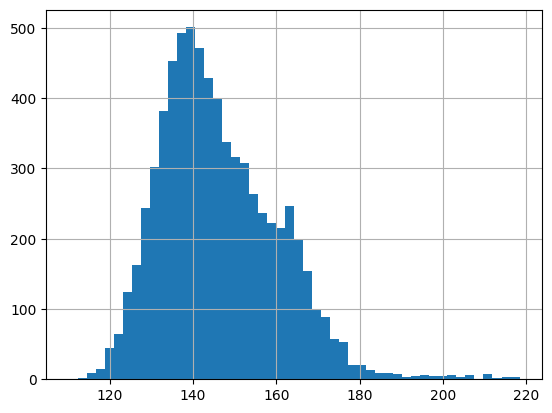

In [22]:
df_trn['img_mean'].hist(bins=50).figure.savefig('../docs/trn_img_mean.png')

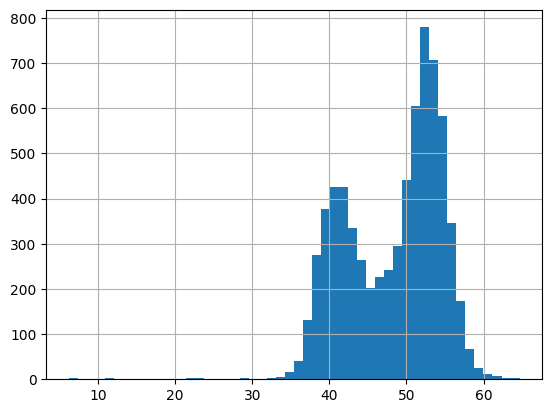

In [23]:
df_trn['img_std'].hist(bins=50).figure.savefig('../docs/trn_img_std.png')

In [25]:
df_trn.to_csv('../metadata/trn_img_meta_7033.csv', index=False)

## provided csvs

In [26]:
df_tile = pd.read_csv('/hdd-pool/hubmap-hacking-the-human-vasculature/tile_meta.csv')
df_wsi = pd.read_csv('/hdd-pool/hubmap-hacking-the-human-vasculature/wsi_meta.csv')

In [28]:
df_tile.shape, df_wsi.shape

((7033, 5), (4, 7))

In [29]:
df_tile.head()

,id,source_wsi,dataset,i,j
0,0006ff2aa7cd,2,2,16896,16420
1,000e79e206b7,6,3,10240,29184
2,00168d1b7522,2,2,14848,14884
3,00176a88fdb0,7,3,14848,25088
4,0033bbc76b6b,1,1,10240,43008


In [33]:
df_tile['dataset'].value_counts()

dataset
3    5400
2    1211
1     422
Name: count, dtype: int64

In [34]:
df_tile['source_wsi'].value_counts()

source_wsi
6     600
7     600
8     600
9     600
10    600
11    600
12    600
13    600
14    600
1     507
2     445
3     410
4     271
Name: count, dtype: int64

In [31]:
df_wsi

,source_wsi,age,sex,race,height,weight,bmi
0,1,58,F,W,160.0,59.0,23.0
1,2,56,F,W,175.2,139.6,45.5
2,3,73,F,W,162.3,87.5,33.2
3,4,53,M,B,166.0,73.0,26.5


In [32]:
df_tile.to_csv('../metadata/tile_meta_7033.csv', index=False)
df_wsi.to_csv('../metadata/wsi_meta.csv', index=False)

## polygons

### copy data to `algo_data` and create parent folders with ID

In [139]:
from kaggle_hubmap.data_utils.core import make_concurrent
from kaggle_hubmap.data_utils.annotations import copy_to_id_parent_dir

In [136]:
dst_dir = '/hdd-pool/hubmap-hacking-the-human-vasculature/algo_data'

In [140]:
_ = make_concurrent(copy_to_id_parent_dir, trn_paths, dst_dir=dst_dir, progress=True)

### read polygons file and create dataframe with annotations

In [141]:
from kaggle_hubmap.data_utils.annotations import read_json_file

In [142]:
polygons_path = '/hdd-pool/hubmap-hacking-the-human-vasculature/polygons.jsonl'

In [143]:
json_data = read_json_file(polygons_path)

In [144]:
df_poly = pd.DataFrame(json_data)

In [147]:
df_poly.shape

(1633, 2)

In [28]:
df_poly.to_csv('../metadata/polygons_1633.csv', index=False)

### collect data copied to `algo_data` and create seg masks

In [2]:
from kaggle_hubmap.data_utils.core import make_concurrent, get_paths
from kaggle_hubmap.data_utils.annotations import convert_point_annotations_to_mask_array

In [3]:
img_paths = get_paths('/hdd-pool/hubmap-hacking-the-human-vasculature/algo_data/', 'img.tif')

INFO:kaggle_hubmap.data_utils.core:Found 7033 paths in "/hdd-pool/hubmap-hacking-the-human-vasculature/algo_data/" matching keyword "img.tif"


In [29]:
df_poly = pd.read_csv('../metadata/polygons_1633.csv')

In [30]:
df_poly.shape

(1633, 2)

In [5]:
_ = make_concurrent(
    convert_point_annotations_to_mask_array, 
    img_paths, 
    annotations_df=df_poly, 
    progress=True)

INFO:kaggle_hubmap.data_utils.annotations:Converting annotations to mask for image 0006ff2aa7cd
INFO:kaggle_hubmap.data_utils.annotations:Converting annotations to mask for image 00168d1b7522
INFO:kaggle_hubmap.data_utils.annotations:Converting annotations to mask for image 0033bbc76b6b
INFO:kaggle_hubmap.data_utils.annotations:Converting annotations to mask for image 003504460b3a
INFO:kaggle_hubmap.data_utils.annotations:Converting annotations to mask for image 004daf1cbe75
INFO:kaggle_hubmap.data_utils.annotations:Writing mask to /hdd-pool/hubmap-hacking-the-human-vasculature/algo_data/00168d1b7522/mask.tif
INFO:kaggle_hubmap.data_utils.annotations:Writing mask to /hdd-pool/hubmap-hacking-the-human-vasculature/algo_data/0006ff2aa7cd/mask.tif
INFO:kaggle_hubmap.data_utils.annotations:Converting annotations to mask for image 005715f0a313
INFO:kaggle_hubmap.data_utils.annotations:Converting annotations to mask for image 00654cc08aac
INFO:kaggle_hubmap.data_utils.annotations:Writing mask

## load sample images and masks

In [16]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

from kaggle_hubmap.data_utils.core import get_paths

In [9]:
mask_paths = get_paths('/hdd-pool/hubmap-hacking-the-human-vasculature/algo_data/', 'mask.tif')

INFO:kaggle_hubmap.data_utils.core:Found 1633 paths in "/hdd-pool/hubmap-hacking-the-human-vasculature/algo_data/" matching keyword "mask.tif"


In [10]:
img_paths = [p.replace('mask.tif', 'img.tif') for p in mask_paths]

In [39]:
img = cv2.imread(img_paths[0])
mask = cv2.imread(mask_paths[0], cv2.IMREAD_GRAYSCALE)

In [40]:
mask.shape

(512, 512)

In [41]:
np.unique(mask, return_counts=True)

(array([0, 1, 2], dtype=uint8), array([194952,  10766,  56426]))

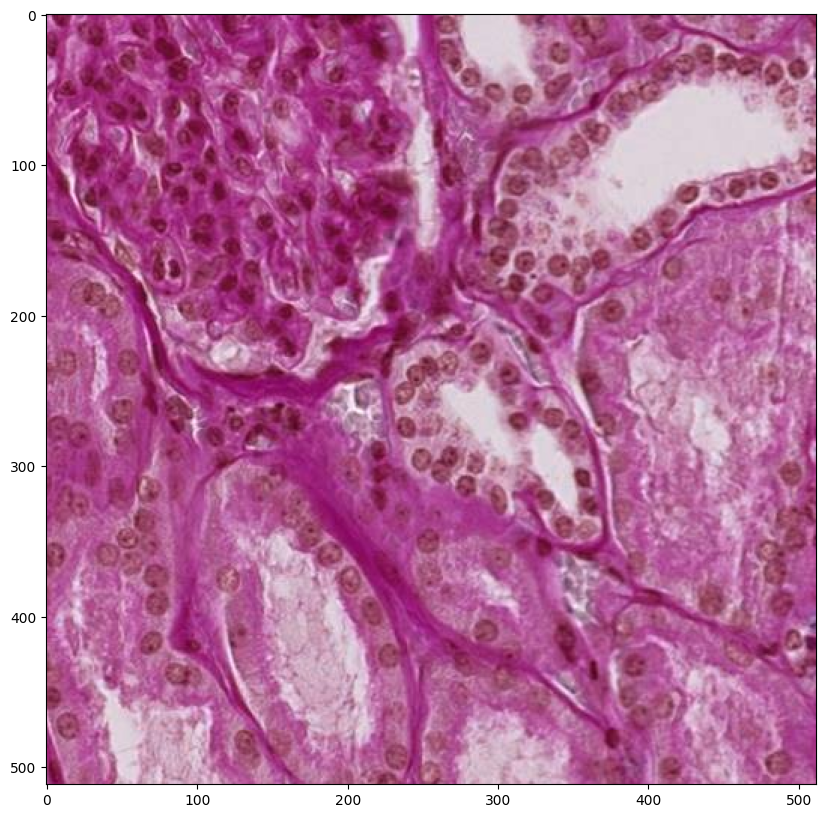

In [49]:
fig = plt.figure(figsize=(10,10))
plt.imshow(img)
# plt.imshow(mask, alpha=0.5)

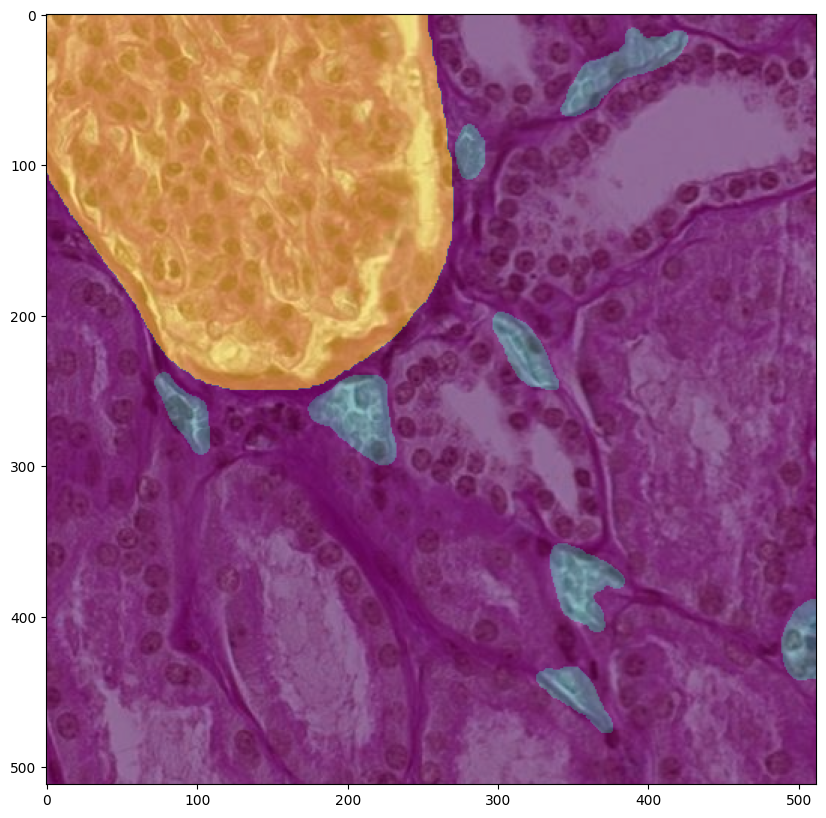

In [47]:
fig = plt.figure(figsize=(10,10))
plt.imshow(img)
plt.imshow(mask, alpha=0.5)

In [48]:
fig.savefig('../docs/image_w_seg.png')

## create segmentation metadata - label counts